# Ollama Function Calling
- By Marcelo Rovai @22Oct25

## Project 1: Calculations

### Python

In [80]:
123456*123456

15241383936

In [83]:
f"{123456*123456:,}"

'15,241,383,936'

### SLM

In [86]:
import ollama

In [89]:
response = ollama.chat(
    model='llama3.2:3B',
    messages=[{
        "role": "user",
        "content": "What is 123456 multiplied by 123456? Only give me the answer"
    }],
    options={"temperature": 0}
)

In [90]:
response.message.content

'151,131,441,376'

`Completely wrong answer`

This is a **fundamental limitation of LLMs** - they're not calculators. Here's why the answer is wrong:

### Why LLMs Fail at Math

#### 1. LLMs Predict Text, They Don't Calculate
- LLMs work by predicting the next most likely token based on patterns in training data
- They don't perform actual arithmetic operations
- They're essentially "guessing" what a plausible answer looks like

#### 2. Tokenization Issues
Numbers are broken into tokens in ways that don't align with mathematical operations:
```
"123456" might tokenize as: ["123", "456"] or ["12", "34", "56"]
```
This makes it nearly impossible for the model to "see" the actual numbers properly for computation.

#### 3. Pattern Matching vs. Computation
- The model has seen similar multiplication problems in training
- It tries to recall patterns rather than compute
- For simple problems (2×3), it might seem to work because it memorizes common facts
- For larger numbers (123456×123456), it has no memorized pattern to fall back on

#### 4. The Correct Answer
```python
123456 × 123456 = 15,241,383,936
```

The LLM will likely give something that "looks" like a big number but is mathematically incorrect.

### The Solution: Function Calling / Tool Use

This is **exactly** why your original code uses function calling! The pattern is:

1. **Use the LLM for understanding intent** (classification)
2. **Use Python for actual computation** (the `multiply()` function)

```python
def multiply(a, b):
    """Actual computation - always correct"""
    result = a * b
    return f"The product of {a} and {b} is {result}."
```

### Why Even Temperature=0 Doesn't Help

Setting `temperature=0` makes the output **deterministic** (same input → same output), but it doesn't make it **correct**. The model will confidently give the same wrong answer every time.

### LLM Math Performance by Problem Type

| Problem Type | LLM Accuracy | Why |
|-------------|--------------|-----|
| 2 + 2 | ~99% | Memorized in training |
| 47 + 89 | ~70% | Some pattern recognition |
| 123 × 456 | ~30% | Struggles with multi-digit |
| 123456 × 123456 | ~0% | No chance without computation |
| Calculate 15% tip on $47.83 | ~40% | Multi-step reasoning fails |

### Best Practices

```python
# ❌ DON'T: Ask LLM to calculate directly
response = ollama.chat(
    model='llama3.2:3b',
    messages=[{"role": "user", "content": "What is 123456 * 123456?"}]
)

# ✅ DO: Use LLM to understand, Python to compute
classification = ask_ollama_for_classification("What is 123456 * 123456?")
if classification["type"] == "multiplication":
    result = multiply(123456, 123456)  # Python does the math
```

**Bottom line:** Use LLMs for natural language understanding and intent classification, but delegate actual computations to proper tools/functions. This is the core principle behind **tool use** and **function calling** in modern LLM applications!

## Function Calling Solution

### Define the Tool (Function Schema)

In [91]:
multiply_tool = {
    "type": "function",
    "function": {
        "name": "multiply_numbers",
        "description": "Multiply two numbers together",
        "parameters": {
            "type": "object",
            "required": ["a", "b"],
            "properties": {
                "a": {"type": "number", "description": "First number"},
                "b": {"type": "number", "description": "Second number"}
            }
        }
    }
}

### Implement the Function

In [93]:
def multiply_numbers(a, b):
    # Convert to int or float as needed
    a = float(a)
    b = float(b)
    return {"result": a * b}

In [95]:
def answer_query(QUERY):
    response = ollama.chat(
        'llama3.2:3B',
        messages=[{"role": "user", "content": QUERY}],
        tools=[multiply_tool]
    )

    # Check if the model wants to call the tool
    if response.message.tool_calls:
        for tool in response.message.tool_calls:
            if tool.function.name == "multiply_numbers":
                # Ensure arguments are passed as numbers
                result = multiply_numbers(**tool.function.arguments)
                print(f"Result: {result['result']:,.2f}")
            else:
                print(f"It is not a Multiplication")
 

In [97]:
answer_query("What is 123456 multiplied by 123456?")

Result: 15,241,383,936.00


In [98]:
answer_query("What is the capital of Brazil?")

Result: 0.00


`To answer it correctly (both ways), we should implement an "agentic approach", which is a subject for later!`

## Project 2: Calculating Distances 

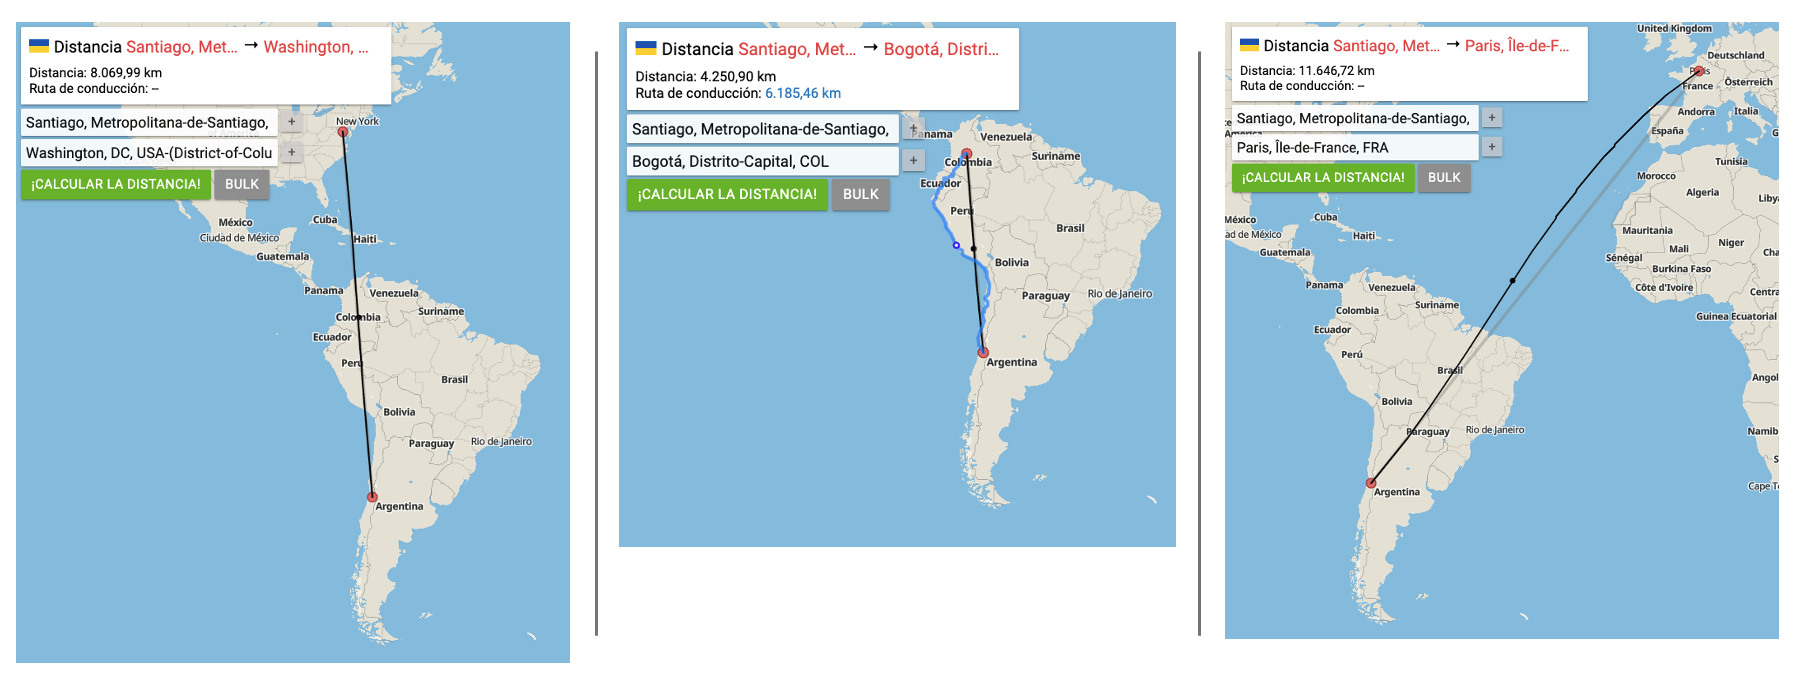

### Testing SLM

In [100]:
def answer_query(QUERY):
    response = ollama.chat(
        'llama3.2:3B',
        messages=[{"role": "user", "content": QUERY}]
    )
    return response.message.content

In [103]:
QUERY= "What is the distance in Km from Santiago de Chile to the capital of France?"
answer_query(QUERY)

'The capital of France is Paris, and Santiago de Chile is a city in Chile.\n\nTo calculate the distance between Santiago de Chile and Paris, we need to know the coordinates of both cities. The coordinates for Santiago de Chile are:\n\n- Latitude: 33°26′S\n- Longitude: 70°36′W\n\nThe coordinates for Paris are:\n\n- Latitude: 48°51′N\n- Longitude: 2°20′E\n\nUsing a distance calculator or an online mapping tool, we can find that the distance between Santiago de Chile and Paris is approximately 11,439 km (7,137 miles).'

In [102]:
QUERY= "What is the distance in Km from Santiago de Chile to the capital of Colombia?"
answer_query(QUERY)

'The capital city of Colombia is Bogotá. The distance between Santiago, Chile and Bogotá, Colombia is approximately 2,700 km (1,680 miles). However, please note that this distance may vary depending on the specific route taken.\n\nTo give you a more accurate answer, here are the approximate distances from Santiago to some major cities in South America:\n\n* Lima, Peru: 3,550 km (2,200 miles)\n* Quito, Ecuador: 3,450 km (2,150 miles)\n* Bogotá, Colombia: 2,700 km (1,680 miles)\n\nPlease let me know if you have any other questions!'

`Each time we got a different and incorrect answer!`

### Solution with Function Calling

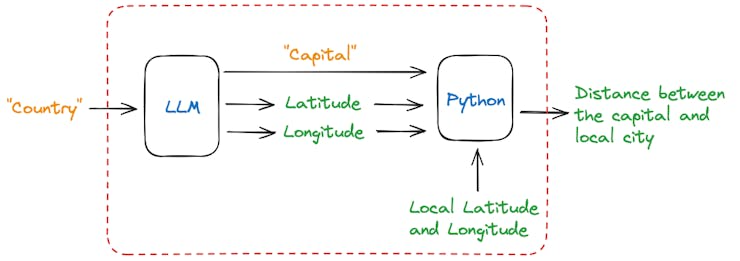

### Importing Libraries

- **haversine**: A function from the haversine library that calculates the distance between two geographic points using the Haversine formula.

In [7]:
import time
from haversine import haversine
from ollama import chat

### Defining Input and Model

On a python string, it is possible get the country from command-line arguments

In this notebook, we should define the country name as a variable

In [57]:
country = "Colombia"

In [58]:
MODEL = 'llama3.2:3B'   # The name of the model to be used
mylat = -33.33          # Latitude of Santiago de Chile
mylon = -70.51          # Longitude of Santiago de Chile

### Defining a Python Function That Acts as a Tool

In [59]:
def calc_distance(lat, lon, city):
    """Compute distance and print a descriptive message."""
    distance = haversine((mylat, mylon), (lat, lon), unit="km")
    msg = f"\nSantiago de Chile is about {int(round(distance, -1)):,} kilometers away from {city}."
    return {"city": city, "distance_km": int(round(distance, -1)), "message": msg}

### Declaring the tool descriptor (schema)

In [60]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "calc_distance",
            "description": "Calculates the distance from Santiago, Chile to a given city's coordinates.",
            "parameters": {
                "type": "object",
                "properties": {
                    "lat": {"type": "number", "description": "Latitude of the city"},
                    "lon": {"type": "number", "description": "Longitude of the city"},
                    "city": {"type": "string", "description": "Name of the city"}
                },
                "required": ["lat", "lon", "city"]
            }
        }
    }
]

### Asking the Model to Use the Tool

In [61]:
def ask_and_measure(country):
    """Let Ollama find the capital and call the local Python function."""
    start = time.perf_counter()

    response = chat(
        model=MODEL,
        messages=[{
            "role": "user",
            "content": f"Find the decimal latitude and longitude of the capital of {country},"
                       " then use the calc_distance tool to determine how far it is from Santiago de Chile."
        }],
        tools=tools
    )
    return response

In [62]:
response = ask_and_measure(country)
response

ChatResponse(model='llama3.2:3B', created_at='2025-10-17T18:27:49.842521004Z', done=True, done_reason='stop', total_duration=9196115725, load_duration=207209859, prompt_eval_count=223, prompt_eval_duration=2668307535, eval_count=32, eval_duration=6319895710, message=Message(role='assistant', content='', thinking=None, images=None, tool_name=None, tool_calls=[ToolCall(function=Function(name='calc_distance', arguments={'city': 'Bogota', 'lat': 4.6583, 'lon': -74.0961}))]))

In [63]:
resp = response.message.tool_calls
resp[0]

ToolCall(function=Function(name='calc_distance', arguments={'city': 'Bogota', 'lat': 4.6583, 'lon': -74.0961}))

In [69]:
for call in response.message.tool_calls:
    raw_args = call["function"]["arguments"]
raw_args

{'city': 'Bogota', 'lat': 4.6583, 'lon': -74.0961}

In [70]:
city = raw_args['city'] 
lat = float(raw_args['lat'])
lon = float(raw_args['lon'])
city, lat, lon

('Bogota', 4.6583, -74.0961)

### Calculating the Distance

In [71]:
distance = haversine((mylat, mylon), (lat, lon), unit='km')
distance

4240.961800075008

In [72]:
print(f"Santiago de Chile is about {int(round(distance, -1)):,} kilometers away from {city}.")

Santiago de Chile is about 4,240 kilometers away from Bogota.


### Creating a function

In [73]:
def calc_dist(country, model=MODEL):
    
    start_time = time.perf_counter()  # Start timing

    # Ask Ollama for structured data
    """Let Ollama find the capital and call the local Python function."""
    start = time.perf_counter()

    response = chat(
        model=MODEL,
        messages=[{
            "role": "user",
            "content": f"Find the decimal latitude and longitude of the capital of {country},"
                       " then use the calc_distance tool to determine how far it is from Santiago de Chile."
        }],
        tools=tools
    )

    for call in response.message.tool_calls:
        raw_args = call["function"]["arguments"]
    city = raw_args['city'] 
    lat = float(raw_args['lat'])
    lon = float(raw_args['lon'])
    
    distance = haversine((mylat, mylon), (lat, lon), unit='km')
    
    end_time = time.perf_counter()  # End timing
    elapsed_time = end_time - start_time  # Calculate elapsed time
    
    print(f"\nSantiago de Chile is about {int(round(distance, -1)):,} kilometers away from {city}.") 
    print(f"[INFO] ==> {MODEL}: {elapsed_time:.1f} seconds")


In [74]:
calc_dist('france', model=MODEL)


Santiago de Chile is about 11,630 kilometers away from Paris.
[INFO] ==> llama3.2:3B: 9.7 seconds


In [75]:
calc_dist('colombia')


Santiago de Chile is about 4,240 kilometers away from Bogotá.
[INFO] ==> llama3.2:3B: 10.4 seconds


In [76]:
calc_dist('united states')


Santiago de Chile is about 8,290 kilometers away from United States.
[INFO] ==> llama3.2:3B: 7.3 seconds


### Using Llama3.2:1B

In [77]:
MODEL = 'llama3.2:1B'
calc_dist('france')
calc_dist('colombia')
calc_dist('united states')


Santiago de Chile is about 10,990 kilometers away from Paris.
[INFO] ==> llama3.2:1B: 29.9 seconds

Santiago de Chile is about 4,260 kilometers away from Bogotá.
[INFO] ==> llama3.2:1B: 8.4 seconds

Santiago de Chile is about 8,160 kilometers away from Washington.
[INFO] ==> llama3.2:1B: 6.3 seconds


`To work with function calling (tools), the model should be prepared for that. LLama works fine, but Gemma, for example, does not support tools.`

### Using gemma3n:e2b

In [78]:
MODEL = 'gemma3n:e2b'
calc_dist('france')
calc_dist('colombia')
calc_dist('united states')

ResponseError: registry.ollama.ai/library/gemma3n:e2b does not support tools (status code: 400)

### Using gemma3:4b

In [79]:
MODEL = 'gemma3:4b'
calc_dist('france')
calc_dist('colombia')
calc_dist('united states')

ResponseError: registry.ollama.ai/library/gemma3:4b does not support tools (status code: 400)